In [31]:
import itertools
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

from gpmodel import gpmodel, gpkernel, gptools, chimera_tools

In [3]:
df = pd.read_csv('../inputs/ENRICHMENT_AVERAGE.TXT', delimiter='\t', header=None)
del df[5]
df.columns = ['sequence', 1, 2, 3, 4]
df.head()

,sequence,1,2,3,4
0,CQIP,0.000000,0.000000,0.0,0.00
1,NM*G,0.000010,0.000010,0.0,0.00
2,WIPY,0.000010,0.000010,0.0,0.00
3,SSGD,0.036361,0.094679,0.0,0.25
4,FGGK,0.000010,0.003922,0.0,0.00


In [4]:
keep = ['*' not in sequence for sequence in df.loc[:, 'sequence']]
df = df[keep]
df.head()

,sequence,1,2,3,4
0,CQIP,0.000000,0.000000,0.0,0.00
2,WIPY,0.000010,0.000010,0.0,0.00
3,SSGD,0.036361,0.094679,0.0,0.25
4,FGGK,0.000010,0.003922,0.0,0.00
5,WYIR,0.000010,0.000010,0.0,0.00


In [6]:
# Find wt sequence AVST
# Make overall split with one-hot/tokens
# Subsample with two and three-site

(160000, 5)

In [22]:
wt = 'AVST'
dfs = {}
for i, j in itertools.combinations(range(4), 2):
    inds = [s[i] == wt[i] and s[j] == wt[j] for s in df['sequence'].values]
    dfs[(i, j)] = df[inds]
    print((i, j), np.mean(df[inds].average))

(0, 1) -2.1127284880425825
(0, 2) -0.5602594940760849
(0, 3) -2.62100536020964
(1, 2) -2.2648129216449733
(1, 3) -3.9750064679172685
(2, 3) -2.446800996982878


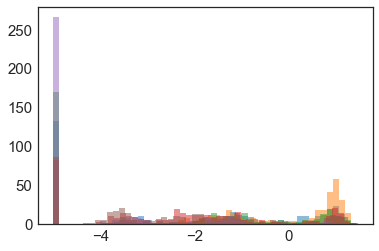

In [34]:
for i, j in itertools.combinations(range(4), 2):
    _ = plt.hist(dfs[(i, j)]['average'], bins=50, alpha=0.5)

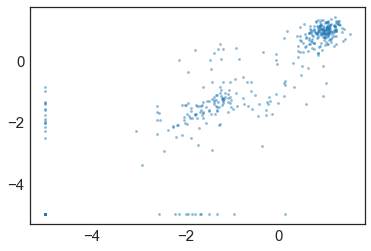

In [20]:
_ = plt.plot(dfs[(0, 2)][1], dfs[(0, 2)][2], '.', alpha=0.5)

In [29]:
np.random.seed(20)
traintest = np.random.choice(df.index, size=2000, replace=False)
train_inds = traintest[:1000]
test_inds = traintest[1000:]

inds = {'train': train_inds, 'test': test_inds}

for i, j in itertools.combinations(range(4), 2):
    ind = [s[i] == wt[i] and s[j] == wt[j] for s in df['sequence'].values]
    inds[(i, j)] = ind
    
for i, j, k in itertools.combinations(range(4), 3):
    ind = [s[i] == wt[i] and s[j] == wt[j] and s[k] == wt[k] for s in df['sequence'].values]
    inds[(i, j, k)] = ind

In [27]:
def make_Xs(df):
    """ Make sure df has the index you want for the Xs"""
    contacts = list(itertools.combinations((0, 1, 2, 3), 2))

    amino_acids = 'ARNDCQEGHILKMFPSTWYV'

    sample_space = [amino_acids for _ in range(len(df.iloc[0]['sequence']))]
    seq_terms = chimera_tools.make_sequence_terms(sample_space)
    struct_terms = chimera_tools.contacting_terms(sample_space, contacts)
    all_terms = seq_terms + struct_terms
 
    seqs = df['sequence'].values
    struct_X, _ = chimera_tools.make_contact_X(seqs, None, contacts,
                                               contact_terms=struct_terms)
    seq_X, _ = chimera_tools.make_sequence_X(seqs, sample_space=sample_space,
                                             sequence_terms=seq_terms)
    all_X = np.concatenate([seq_X, struct_X], axis=1)
    X_dumb = np.zeros((len(df), len(df.iloc[0]['sequence'])))
    aa = np.array(sorted(amino_acids))
    for i, seq in enumerate(seqs):
        for j, s in enumerate(seq):
            X_dumb[i, j] = np.argwhere(aa == s).flatten()

    return all_X, seq_X, X_dumb

_, X, T = make_Xs(df)
y = df.loc[:, 'average']

In [32]:
with open('../inputs/phoq.pkl', 'wb') as f:
    pickle.dump((X, T, y, inds), f)